In [1]:
import os
import shutil

# Paths
DATASET_DIR = '/kaggle/input/plantvillage/PlantVillage'
train_dir = os.path.join(DATASET_DIR, 'train')
val_dir = os.path.join(DATASET_DIR, 'val')
merged_dir = os.path.join('/kaggle/working', 'merged_data')  # Create in working directory

os.makedirs(merged_dir, exist_ok=True)

def merge_folders(src, dst):
    for class_name in os.listdir(src):
        src_class_path = os.path.join(src, class_name)
        dst_class_path = os.path.join(dst, class_name)

        os.makedirs(dst_class_path, exist_ok=True)

        for filename in os.listdir(src_class_path):
            src_file = os.path.join(src_class_path, filename)
            dst_file = os.path.join(dst_class_path, filename)
            shutil.copy2(src_file, dst_file)

# Merge both folders into merged_data
merge_folders(train_dir, merged_dir)
merge_folders(val_dir, merged_dir)

print("✅ Train and Val data successfully merged into:", merged_dir)


✅ Train and Val data successfully merged into: /kaggle/working/merged_data


In [2]:
import os

base_dir = '/kaggle/working/merged_data'
new_base = '/kaggle/working/final_split'  # where new folders will be created

splits = ['train', 'val', 'test']

for split in splits:
    for class_name in os.listdir(base_dir):
        split_dir = os.path.join(new_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)


In [3]:
import random
import shutil

split_ratios = {'train': 0.8, 'val': 0.1, 'test': 0.1}

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratios['train'] * total)
    val_end = train_end + int(split_ratios['val'] * total)

    split_data = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split in splits:
        for img in split_data[split]:
            src = os.path.join(class_path, img)
            dst = os.path.join(new_base, split, class_name, img)
            shutil.copy2(src, dst)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    os.path.join(new_base, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(new_base, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(new_base, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


2025-04-10 13:24:16.792633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744291456.980571      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744291457.036146      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing import image

# Define input shape and number of classes
input_shape = (224, 224, 3)
n_classes = 38

# Use the Functional API to build the model
inputs = layers.Input(shape=input_shape)
x = layers.BatchNormalization()(inputs)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

I0000 00:00:1744291471.704304      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 107, 107, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           2,4

 Total params: 11,014,130 (42.02 MB)

 Trainable params: 11,014,124 (42.02 MB)

 Non-trainable params: 6 (24.00 B)

In [6]:
import keras
from keras import layers
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [7]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744291482.201384     110 service.cc:148] XLA service 0x79c2f00027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744291482.202259     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744291482.784312     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1358 ━━━━━━━━━━━━━━━━━━━━ 1:18 58ms/step - accuracy: 0.0547 - loss: 3.6371  

I0000 00:00:1744291491.204394     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 456s 323ms/step - accuracy: 0.3076 - loss: 2.6565 - val_accuracy: 0.6256 - val_loss: 1.3641
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 429s 314ms/step - accuracy: 0.6551 - loss: 1.1870 - val_accuracy: 0.7465 - val_loss: 0.9172
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 431s 316ms/step - accuracy: 0.7681 - loss: 0.7541 - val_accuracy: 0.7729 - val_loss: 0.8763
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 428s 314ms/step - accuracy: 0.8303 - loss: 0.5371 - val_accuracy: 0.7920 - val_loss: 0.7804
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 431s 316ms/step - accuracy: 0.8624 - loss: 0.4334 - val_accuracy: 0.8309 - val_loss: 0.5969
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 427s 313ms/step - accuracy: 0.8860 - loss: 0.3549 - val_accuracy: 0.8152 - val_loss: 0.6361
Epoch 7/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 429s 314ms/step - accuracy: 0.9006 - loss: 0.3152 - val_accuracy: 0.8060 - val_loss: 0.7710
Epoch 8/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 428s 314ms/step - accuracy: 0.9

In [14]:
model.save('/kaggle/working/crop_disease_model_combined_data_augmentation.h5')

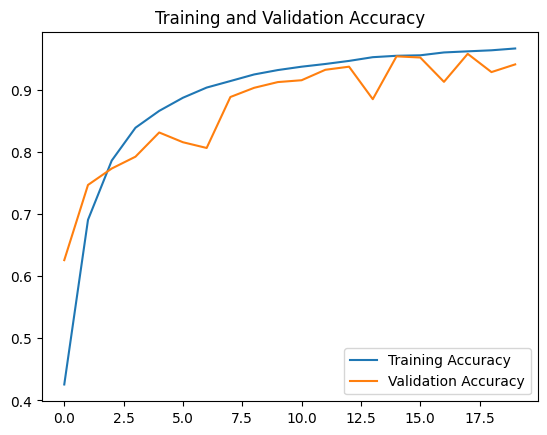

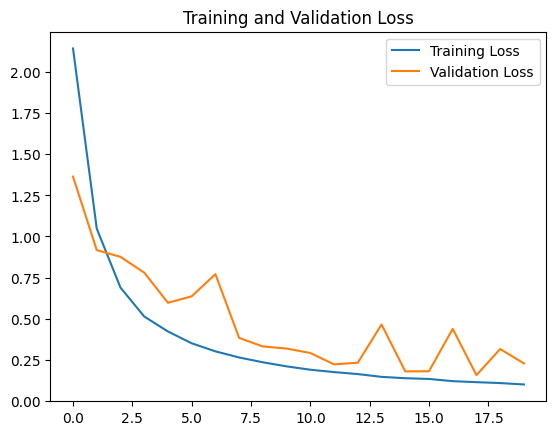

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
EPOCHS = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#plt.figure(figsize=(8,8))
#plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.subplot(1, 2, 2)
plt.show()
plt.savefig('AccVal_acc')
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('LossVal_loss')

In [11]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9420 - loss: 0.2080
Test Accuracy: 93.24%


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Predict on test data
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)

# Step 2: True labels
y_true = test_gen.classes

# Step 3: Get class labels
class_labels = list(test_gen.class_indices.keys())

# Step 4: Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Optional: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step
Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.83      0.90      0.86        63
                                 Apple___Black_rot       0.89      1.00      0.94        63
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        28
                                   Apple___healthy       0.92      0.87      0.89       165
                               Blueberry___healthy       0.94      0.99      0.96       151
          Cherry_(including_sour)___Powdery_mildew       0.99      0.94      0.97       106
                 Cherry_(including_sour)___healthy       0.95      1.00      0.97        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.96      0.86        52
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
             

171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


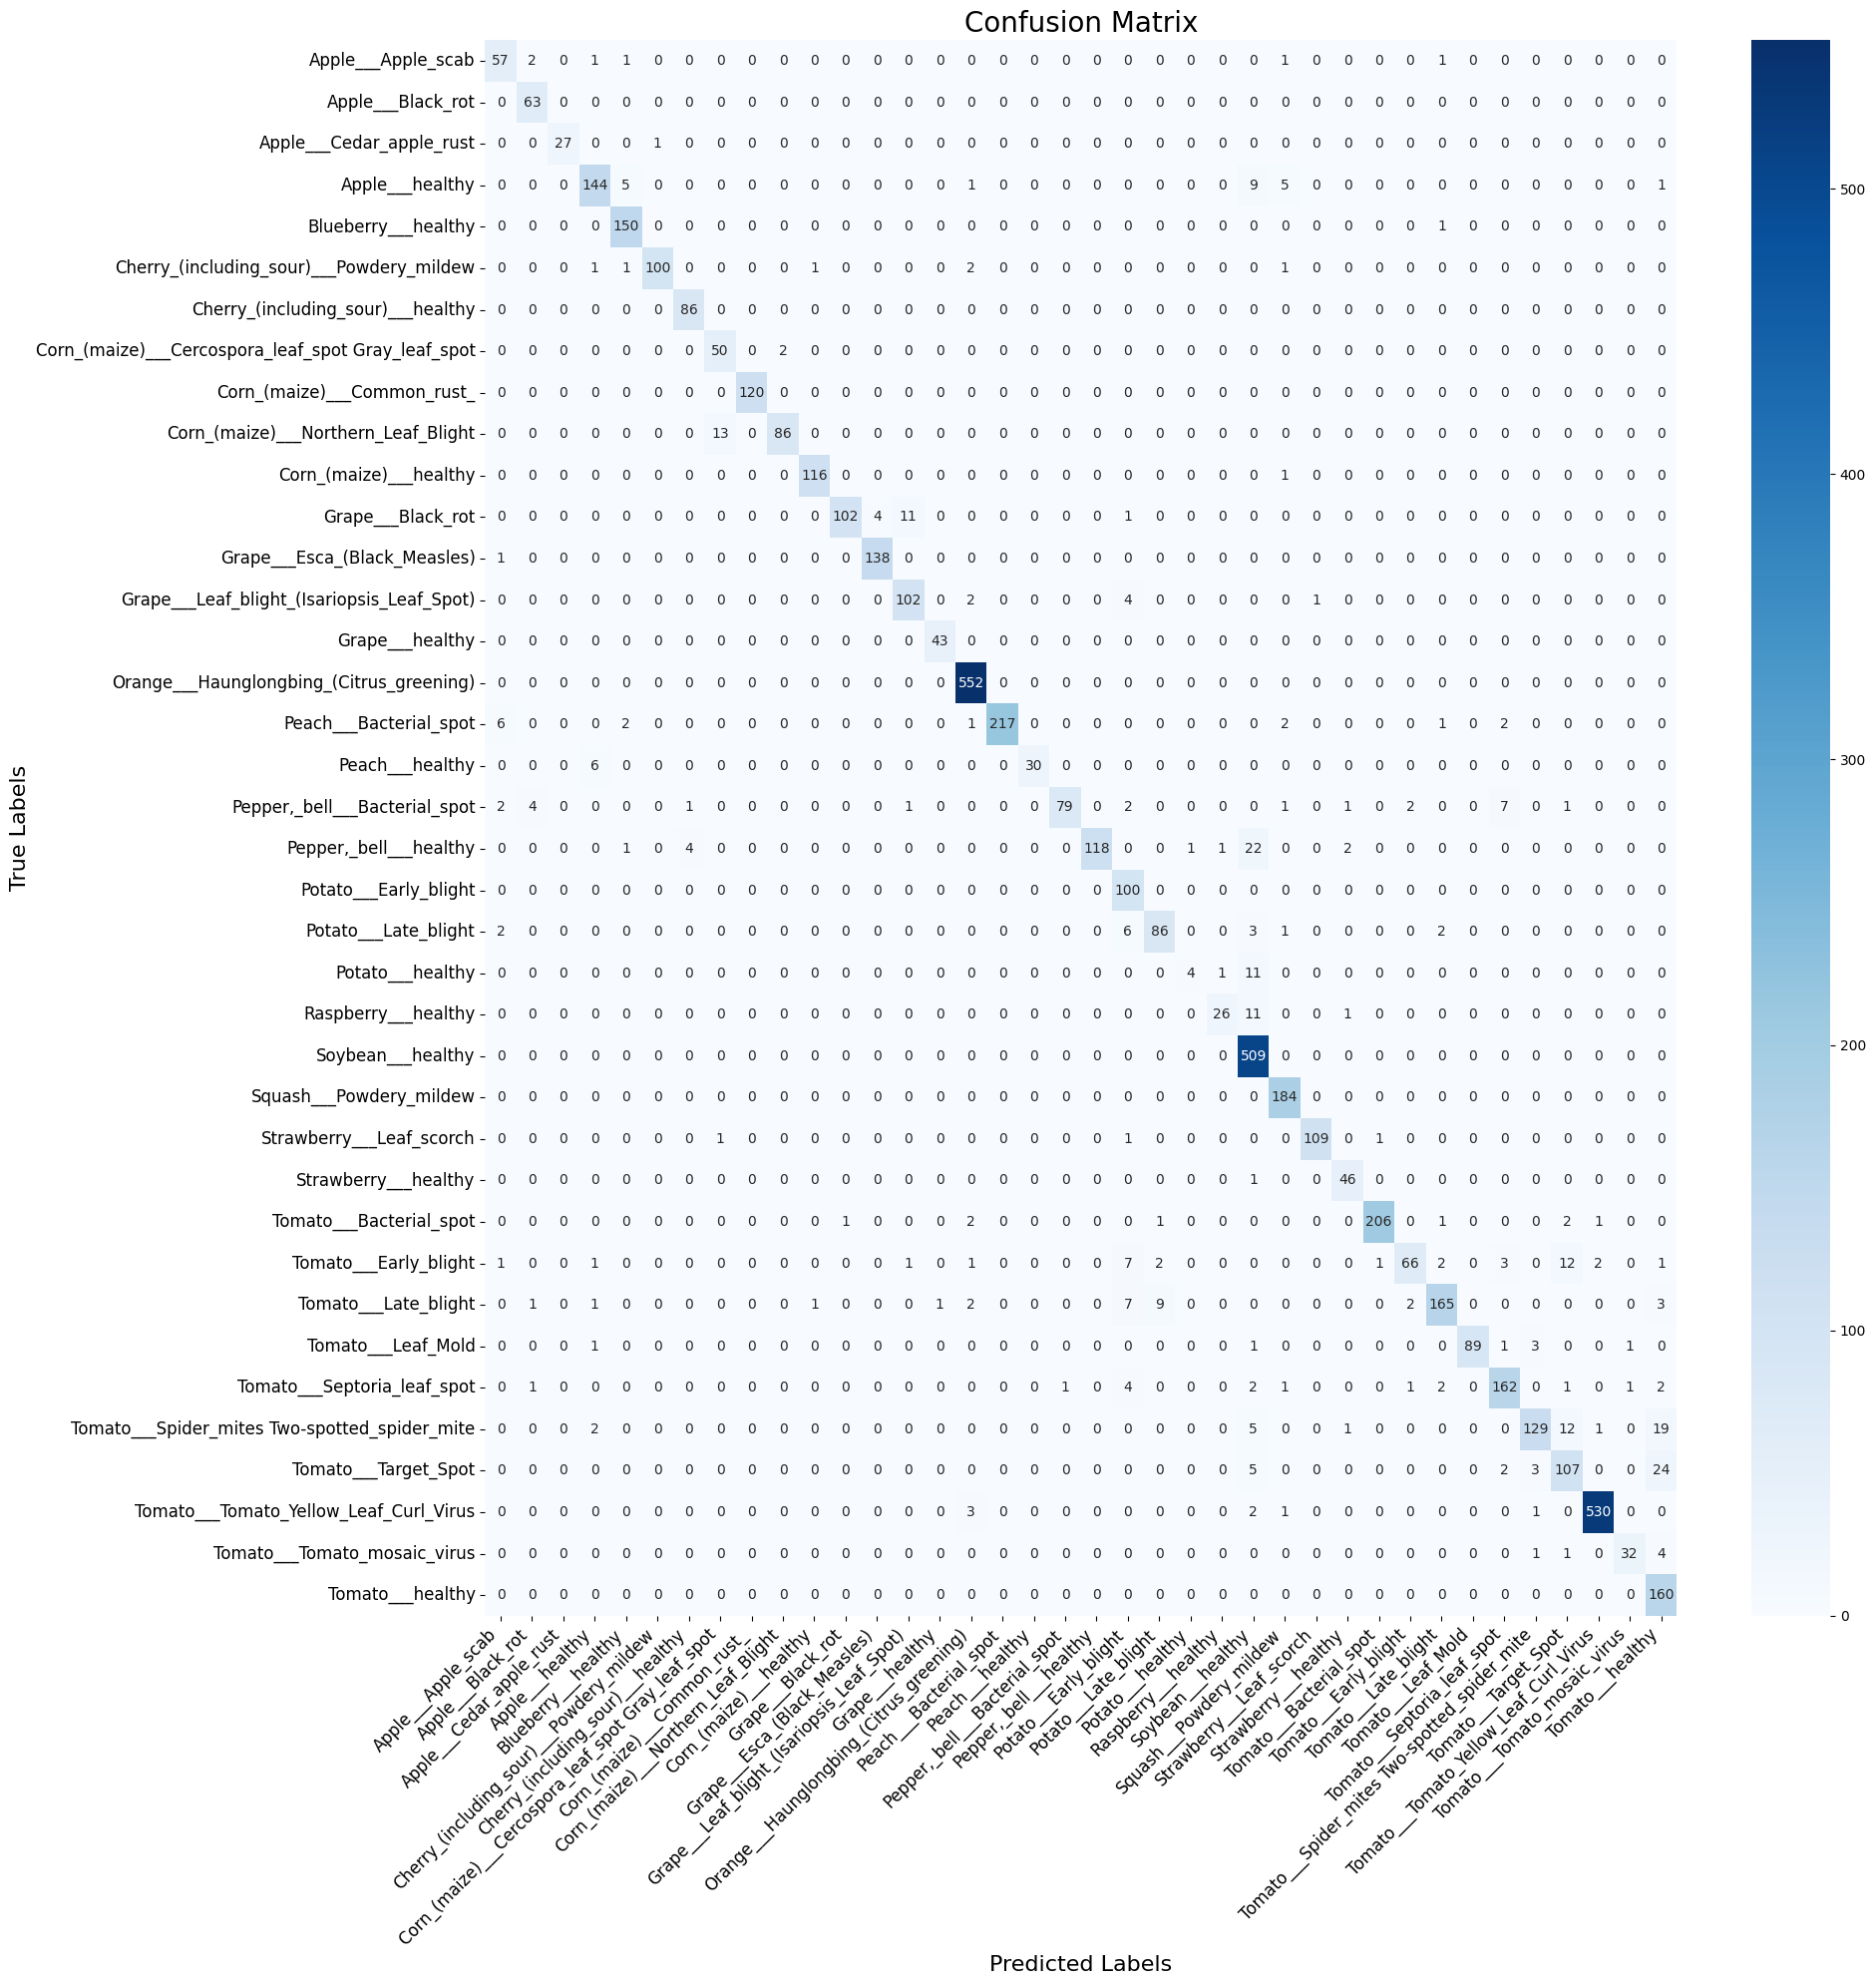

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Recompute if not done already
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_names = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Set figure size dynamically
plt.figure(figsize=(20, 20))  # Adjust size based on number of classes

# Plot with heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True)

plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()
